# 教程 5：使用 Eryn 的 RJMCMC

在第五个教程中，我们将研究底层模型改变时后要怎么使用 Eryn，也就是要使用可逆跳转 MCMC（也称为跨维 MCMC）。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # 可能有用

## 任务 1：有几个高斯脉冲？

第一个 RJ 问题是确定噪声数据集中存在多少个二维高斯脉冲。为了简化问题，采用基于先验分布的方案（默认设置）。如果在EnsembleSampler的设置中设置`rj_moves=True`，它就会自动根据先验分布生成RJ方案。不过，在使用多个分支（模型类型）时一定要小心，因为默认情况下，这个提议会对采样器中的每个模型的 1 个模型计数进行更改，即增加或者删除。

In [2]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend
from chainconsumer import ChainConsumer, Chain

设置二维网格的 x 和 y 尺寸。

In [3]:
num     = 100 # 每个维度的步长
lowlim  = -10 # 坐标轴的最低限制
highlim = 10  # 坐标轴的最高限制
npulses = 10  # 注入脉冲数

dx = (highlim - lowlim) / num # 得到离散值

x, y = np.mgrid[lowlim:highlim:dx, lowlim:highlim:dx]  # 生成网格

为每组脉冲绘制初始参数。每个脉冲都有振幅、X 和 Y 值。

In [4]:
Amp    = np.random.uniform(.5, 2.0, size=(npulses)) # 振幅
spread = .2  # 假设传播范围固定
sigma  = spread * np.diag(np.ones(2))

edges = 2 

# 坐标参数
# 生成随机x，y
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

# 收集所有参数
gauss_inj_params = np.concatenate([Amp[:, None], inj_coordinates], axis=1)

print(' * Parameters injected: \n\n', np.matrix(gauss_inj_params))

 * Parameters injected: 

 [[ 0.73234171  4.13258469  1.32163955]
 [ 1.17150841 -2.17605087 -4.16369758]
 [ 1.64934333  2.10757815 -0.03389733]
 [ 1.85960535 -5.30477376 -0.32954994]
 [ 0.65342984  4.515854   -0.14247514]
 [ 1.42104826 -0.86161095 -6.28023237]
 [ 1.92567033  3.84610108 -5.39843791]
 [ 1.06160283  0.32825166 -3.98749412]
 [ 1.1687714   5.80224162 -1.3797489 ]
 [ 0.73601719  3.59736547 -0.84019023]]


填入高斯函数和概率，避免出现错误。接下来的几个区域给出了注入数据的概念。

In [5]:
# 计算高斯模型的一些常数项
sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    # breakpoint()
    A = np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * sigma[0,0]))
    B = np.exp(-((y[None, :] - c[:, None]) ** 2) / (2 * sigma[1,1]))
    # breakpoint()
    C =  A[:, None, :] * B[:, :, None] # (np.expand_dims(A,axis=0) * np.expand_dims(np.transpose(B),axis=2))

    return a[:, None, None] * C / norm

def log_prob_fn(x1, X, Y, data, sig):

    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]
    n = num * num

    template  = np.sum(gaussian(X, Y, a, b, c), axis=0)

    llh = - 0.5 * ( np.sum(((template - data)) ** 2) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

In [6]:
noise = spread * np.random.randn( num, num ) # Draw the random points for the noise

# 生成数据集
injection = np.zeros( (num, num) )
injection = np.sum(gaussian(x, y, gauss_inj_params[:, 0], gauss_inj_params[:, 1], gauss_inj_params[:, 2]), axis=0)
data = injection + noise


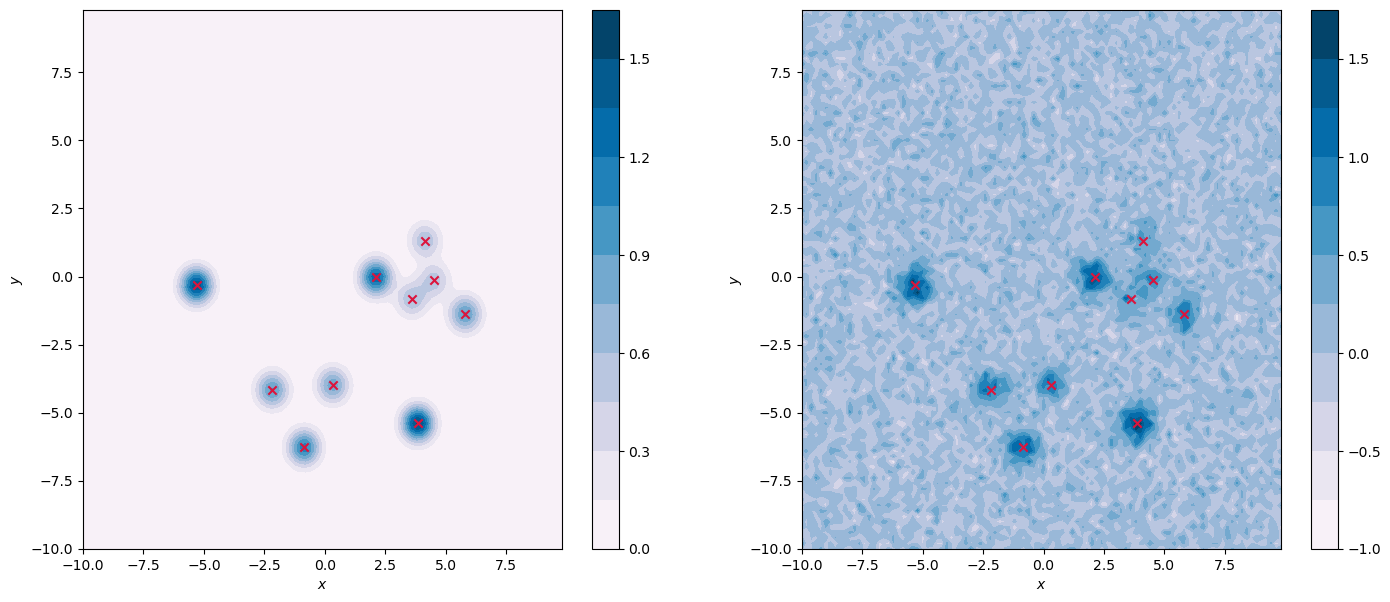

In [7]:
from matplotlib import cm

plt.figure(figsize=(17,7))
plt.subplot(121)
cf = plt.contourf(y, x, injection, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.colorbar(cf)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(122)
cf = plt.contourf(y, x, data, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(cf)
plt.show()


我们已经完成了大部分初始设置，需要进行采样。首先构建基本条件：ndims、nleaves_max、nleaves_min、branch_names、ntemps、nwalkers。

In [8]:
ntemps = 10
nwalkers = 30

ndims        = {"pulse": 3}           # 采样两个模型的尺寸（每个脉冲和噪声的参数）
nleaves_max  = {"pulse": 2*npulses}   # 每种模型类型的最大分量数（噪声为 1）
nleaves_min = {"pulse": 0}
branch_names = ["pulse"]

设置先验函数需要使用 Eryn 的 ProbDistContainer 对象初始化先验。

* 振幅使用从 0.5 到 2.0 的均匀先验值。
* x 和 y在可接受范围内使用统一先验。

In [9]:
priors = {
    "pulse": ProbDistContainer({
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    })
}

使用 RJMCMC 时，我们必须在 EnsembleSampler 中输入移动值。这是因为默认方案（Stretch 方案）无法在不同维度下工作。使用以当前点为中心的高斯方案。建议使用对角协方差矩阵，或者其他的使每个参数的协方差都相同的方法。

In [10]:
# imports 
from eryn.moves import GaussianMove

In [11]:
factor = 0.01
cov    = {"pulse": np.diag(np.ones(3)) * factor}
moves = GaussianMove(cov)

现在我们将实例化 EnsembleSampler。对于退火，设置 `tempering_kwargs=dict(ntemps=ntemps)`。

In [12]:
ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # 假设 ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data, sigma_det],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,
)

 # 每个游走者的样本数

准备好采样器后，只需要生成起始点。这方面有很多选择方式，在 RJMCMC 中，由于模型的不确定性，情况更为复杂。在这个简化的例子中，从先验中为每个游走者抽出 1 个高斯。随着时间的推移，它还会增加。生成一个形状为（ndemps、ndwalkers、ndleaves_max、ndim）的坐标字典，它可以对协调数组中的每个源进行采样，因为我们将使用 inds 字典来指导每个游走者只拥有一个叶，然后对其进行索引，并将每个游走者的一个值设为 True。把字典填入状态对象中。

In [13]:
# 这里的最大叶片数只是为了保证特征正确。开始时，每个游走者只有 1 个叶
coords = {
    name: priors[name].rvs(size=(ntemps, nwalkers, nleaves_max[name]))
    for name in branch_names
} 

inds_tmp = np.zeros(coords['pulse'].shape[:-1], dtype=bool)
inds_tmp[:, :, 0] = True

inds = {'pulse': inds_tmp}
state = State(coords, inds=inds)

运行采样器。最好先进行充分的burn in。

In [14]:
nsteps = 5000
output = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:46<00:00,  7.08it/s]


现在使用 ensemble.backend 读出冷链中每个游走者的叶数量。使用 inds 数组。绘制冷链中发现的脉冲数直方图。这是模型计数的后验分布。

<>:23: SyntaxWarning: invalid escape sequence '\#'
<>:23: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipykernel_5050/449829401.py:23: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("$\#$ of peaks in the data")


Text(0.5, 0, '$\\#$ of peaks in the data')

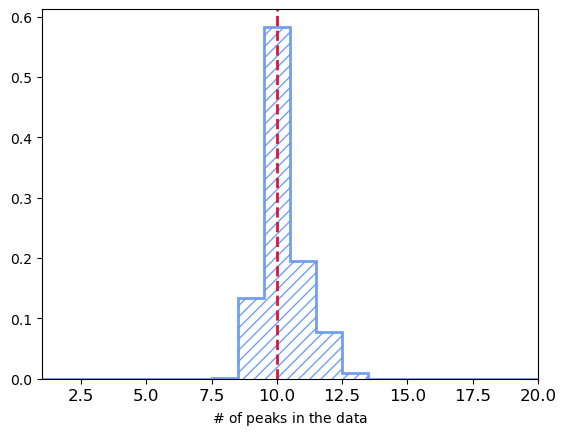

In [15]:
# burn in后的每一步都将获取叶，去掉温度较高的链 
# 这下面只有0个索引
nleaves = ensemble.backend.get_nleaves()["pulse"][:, 0].flatten() 

bins = (np.arange(1, nleaves_max['pulse'] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

plt.hist(
    nleaves,
    bins=bins,
    color='#6495ed',
    alpha=0.9,
    lw=2,
    histtype='step',
    density=True,
    hatch='///'
)

# 注入列

plt.axvline(x=int(npulses), linestyle='--', lw=2, color='#DC143C')
plt.xticks(fontsize=12)
plt.xlim(1, 20)
plt.xlabel("$\#$ of peaks in the data")

### 问题:
这是预期的结果吗？RJMCMC 有没有告诉我们什么是 "正确 "答案？噪声对后验图有何影响？如果增加噪声，预期会出现什么类型的变化，为什么？

### 回答
根据我们的初始设置，这个解答是预期的结果，也就是十个高斯脉冲。噪声可能会影响判断的可信度，也就是使后验图中直方的区域扩大，高度增加，但对中心线的影响可能不会很大。

我们将查看恢复脉冲的参数，以了解注入脉冲的定位效果。要做到这一点，需要从所有发现的叶计数中提取样本，也就是冷链中的每一个源，并将所有内容叠加绘制成图。提示：请充分利用 inds 数组。

推荐使用 pandas 和 chainconsumer 来完成这项工作，但也可以按照自己的喜好。

In [16]:
import pandas as pd

Parameter $A$ in chain Test is not constrained
Parameter $x$ in chain Test is not constrained
Parameter $y$ in chain Test is not constrained


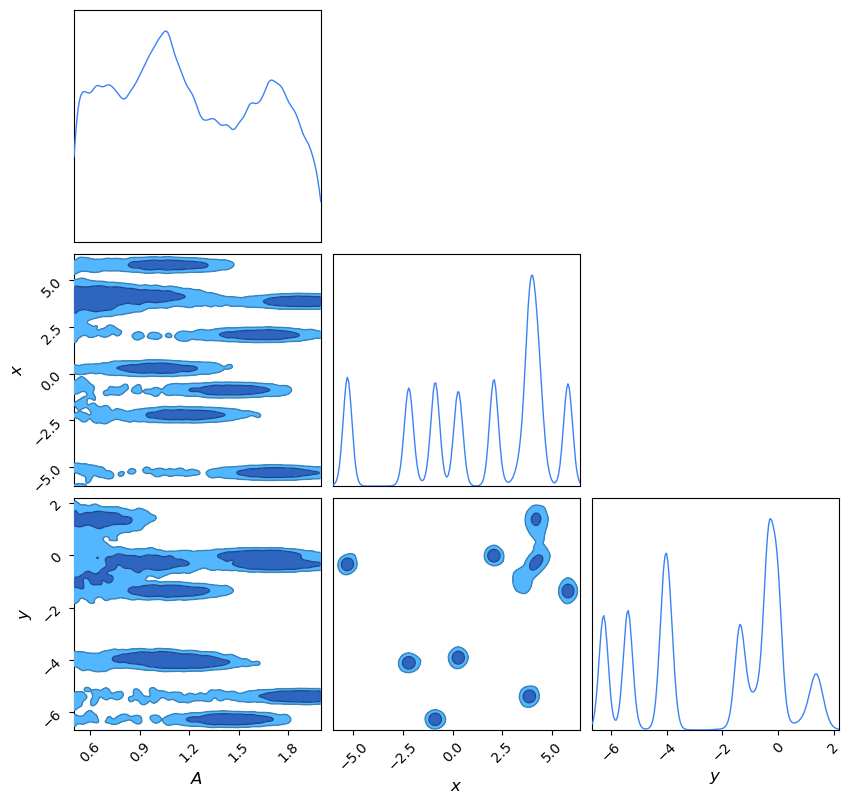

In [17]:
pulse_parameters = ["$A$", r"$x$", r"$y$"]

samples_pulses = ensemble.backend.get_chain()['pulse'][ensemble.backend.get_inds()["pulse"]]

df = pd.DataFrame({key: val for key, val in zip(pulse_parameters, samples_pulses.T)})
c = ChainConsumer()
check = int(3)
c.add_chain(Chain(samples=df, name="Test", smooth=check))
fig = c.plotter.plot()

### 问题:
做得怎么样？成功吗？是否可以改进？

## 回答
这个定位大致上是成功的，考虑到噪声信息对该模型的影响，我认为在进行运算叠加前可以先对数据集进行去噪，减小噪声的干扰。

## 任务 2：使用 RJMCMC 选择模型

使用 RJMCMC 进行直接模型比较。与教程 3 中比较高斯脉冲和柯西脉冲所用的模型相似。在教程 3 中，使用定维 MCMC 和热力学积分来估计每个模型的证据。然后对它们进行比较，得出贝叶斯因子。使用 RJMCMC 将产生模型选择指数的后验分布，而不是每个模型的直接证据率。突出一个模型而非另一个模型的游走者比例代表了几率比的替代值。严格来说，当一种模型比另一种模型更受推荐时，情况并非如此。不过，当模型的推荐度接近时，这种直接计算方法也是可行的。

为简单起见，我们将信号的传播视为 1。因此，我们只对脉冲的振幅和平均值进行拟合和比较。

我们将再次从提供高斯脉冲、柯西脉冲和似然函数开始。

In [18]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

def log_like_wrap(params, *args):
    # must be careful about how these models are read into the Likelihood function
    # In this case, we will have one model with a single set of parameters 
    # and one model that is None
    
    assert len(params) == 2
    if params[0] is not None:
        assert params[1] is None
        # gauss will be first set of params
        args += ("gauss",)
        ll = log_like_fn(params[0][0], *args)

    else:
        assert params[0] is None
        # gauss will be first set of params
        args += ("cauchy",)
        ll = log_like_fn(params[1][0], *args)

    return ll

我们将注入高斯脉冲，并与柯西脉冲进行比较。

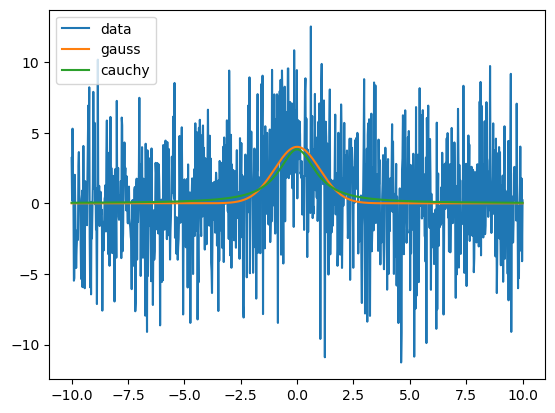

In [19]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 3.5
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data, label="data")
plt.plot(t_vals, true_data, label="gauss")
plt.plot(t_vals, cauchy_data, label="cauchy")
plt.legend()
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

我们将遵循与上一个问题相同的设置顺序。从基本声明（ndemps、ndims 等）开始。对于这个问题，两个模型的最大叶片数都应该是 1，最小叶片数都应该是 0。

In [20]:
ntemps = 10
nwalkers = 30

ndims        = {"gauss": 2, "cauchy": 2}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"gauss": 1, "cauchy": 1}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
nleaves_min = {"gauss": 0, "cauchy": 0}
branch_names = ["gauss", "cauchy"]

把两个模型的先验值放在一起。两个模型的先验其实是一样的。振幅先验应该跨越注入值。平均先验值应跨越时间域。

In [21]:
priors = {}
priors["gauss"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

priors["cauchy"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

我们将生成与之前建立的高斯运动（GaussianMove）相同的类型。需要确保为每个模型提供协方差，因此，它必须是一个字典，其中包含两个模型的条目。不过条目可以是相同的。

In [22]:
factor = 0.01
cov    = {"gauss": np.diag(np.ones(2)) * factor, "cauchy": np.diag(np.ones(2)) * factor}
moves = GaussianMove(cov)

下面实例化 `EnsembleSampler`.

In [23]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    log_like_wrap,
    priors,
    nbranches=2,
    branch_names=branch_names,  # order determines order of parameter sets in Likelihood
    tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf),
    args=(t_vals, data, sigma),
    rj_moves=True,
    moves=moves,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min
)

生成起始点。注意：这一点非常重要。只有在以下情况下，这个测试才会有效

* 我们有 2 个模型、
* 每个模型的最大叶片数为 1，最小叶片数为 0、
* 起始点必须都有高斯脉冲或柯西脉冲，而不是两者都有，也不是两者都没有。
* 在这种设置下，每个提议都会建议切换模型，并从其先验中提取。

生成起点，并使用 inds 数组告诉采样器每个行走器只有一个模型实例。

In [24]:
start_point = {name: priors[name].rvs(size=(ntemps, nwalkers, 1)) for name in branch_names}

# draw randomly which model to start in 
model_index = np.random.randint(0, 2, size=(ntemps, nwalkers, 1))

inds = {name: np.zeros((ntemps, nwalkers, 1), dtype=bool) for name in branch_names}

inds["gauss"][model_index == 0] = True
inds["cauchy"][model_index == 1] = True

assert np.all(inds["gauss"].astype(int) + inds["cauchy"].astype(int) == 1)
start_state = State(start_point, inds=inds)

运行采样器并进行burn in。

In [25]:
nteps = 500
sampler.run_mcmc(start_state, nsteps, progress=True, burn=100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:22<00:00, 15.50it/s]


为了找到我们的后验几率，我们需要得到存在于两种状态之一的冷链样本的分数。计算几率比。

In [26]:
nleaves = sampler.get_nleaves()

In [27]:
# number of cold-chain Gaussians / number of cold-chain samples
nleaves["gauss"][:, 0].sum() / np.prod(nleaves["gauss"][:, 0].shape)

0.13344666666666666

### 问题:
改变噪声会对结果产生什么影响？如果有一种模型准确度非常高，几率是 1，会发生什么情况？这是对几率比的正确估计吗？在初始几率为 1 的情况下，该如何做才能计算出真实几率？

### 回答
噪声可能会增加运算量和影响RJMCMC结果。这种算法通过不断迭代来获取最优解的，如果数据中含有大量的噪声数据，将会大大的影响数据的收敛速度，不能收敛，或者说收敛在错误的位置，无法在正确的点收敛等等。

会导致迭代无法进行，不能进行进一步计算，这可能无法得出正确的结果，因为没有发生游走者位置之间的交换，算法没有运行。经过RJMCMC计算的指数不是模型直接得出的，而且通过游走者的概率计算得出的，所以这个结果在某些时候并不能反映模型真正的性质。

可能需要进行起始点的重新设定，或者对该模型的几率进行处理。

## 学习总结
本章节中介绍了RJMCMC的使用方法。我通过查阅文献，了解了一些RJMCMC的基本信息，它是是MCMC的一个扩展，可以在不同的参数空间模型之间跳跃，在模型选择问题上具有优势。每次迭代中，不仅可以改变参数值，还可以改变参数的数量和结构。

RJMCMC的工作流程：
1) 选择一个当前模型和参数。
2) 随机决定是移动到一个新的参数空间还是在当前参数空间内部移动。
3) 如果决定移动到新的参数空间，执行一个“跳跃”操作，这可能会增加、减少或更改参数的类型。
4) 计算接受这种跳跃的概率，基于目标分布和跳跃的建议分布。
5) 基于计算的概率决定是否接受跳跃。

本教程中通过求解一个二维噪声数据集中有几个高斯脉冲，展示了RJMCMC的编码方式和功能，还有一些需要注意的问题，比如使用分支时数量可能被改变。

根据画出的后验图，我们看到解答符合我们预期的结果。在这个例子中噪声可能会影响判断的可信度，也就是使后验图中直方的区域扩大，高度增加，但对中心线的影响可能不会很大。

RJMCMC还可以对高斯脉冲的位置进行定位，可以看到它的强大性，但当数据的噪声过大时，定位可能不完全准确。这个定位大致上是成功的，考虑到噪声信息对该模型的影响，我认为在进行运算叠加前可以先对数据集进行去噪，减小噪声的干扰。

噪声可能会增加运算量和影响RJMCMC结果。这种算法通过不断迭代来获取最优解的，如果数据中含有大量的噪声数据，将会大大的影响数据的收敛速度，不能收敛，或者说收敛在错误的位置，无法在正确的点收敛等等。

在使用RJMCMC选择模型时，有一些需要注意的要点，经过RJMCMC计算的指数不是模型直接得出的，而且通过游走者的概率计算得出的，这在某些时候可能遇到一些问题。比如给出的模型准确度几率为1，这会导致迭代无法进行，不能进行进一步计算，这可能无法得出正确的结果，因为没有发生游走者位置之间的交换，算法没有运行。

可能需要进行起始点的重新设定，或者对该模型的几率进行处理。
